In [84]:
AMOUNT = 360*26 #360 measurement points per hour * hours
name = 'tum-esm-midcost-raspi-6'

In [85]:
# Imports & Inits

import polars as pl
from datetime import datetime
import asyncpg
import pendulum
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import math
import pyarrow as pa

data = {
        "integer": [],
        "date": [],
        "system name": [],
        "variant": [],
        "CO2_raw": [],
        "CO2_compensated": [],
        "CO2_filtered": [],
        "sht45_humidity": [],
        "bme280_humidity": [],
        "bme280_pressure": [],
        "sht45_temperature": [],
        "bme280_temperature": [],
        "chamber_temperature": [],
        "gas_bottle_id": []
        }

def plot_sensor_measurement(df, sensor_name):
        df_f = df.filter(pl.col("variant") == "measurement") 
        df_f = df_f.sort("date").filter(pl.col(sensor_name) > 0)
        df_f = df_f.groupby_dynamic("date",every='10m').agg(pl.all().exclude('date').mean())

        sns.lineplot(data=df_f,
                x='date',
                y=sensor_name)


        # set axes labels
        plt.xlabel('Date')
        plt.ylabel(sensor_name)
        plt.xticks(rotation=45)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))

        # show the plot
        plt.show()
        
def find_closest_cardinal_direction(degree):
    # Normalize the degree value to be between 0 and 360
    degree = degree % 360

    # Define the cardinal and intermediate directions and their corresponding degrees
    directions = {
        'North': 0,
        'NNE': 22.5,
        'NE': 45,
        'ENE': 67.5,
        'East': 90,
        'ESE': 112.5,
        'SE': 135,
        'SSE': 157.5,
        'South': 180,
        'SSW': 202.5,
        'SW': 225,
        'WSW': 247.5,
        'West': 270,
        'WNW': 292.5,
        'NW': 315,
        'NNW': 337.5
    }

    # Initialize variables to keep track of the closest direction and its degree difference
    closest_direction = None
    min_difference = float('inf')

    # Iterate over the directions and calculate the difference in degrees
    for direction, direction_degree in directions.items():
        difference = abs(degree - direction_degree)

        # Check if the current difference is smaller than the previous minimum difference
        if difference < min_difference:
            min_difference = difference
            closest_direction = direction

    return directions[closest_direction]


In [86]:
# Database connection
f = open('config.json')
CONFIGURATION = json.load(f)

# Connect to the database
client = await asyncpg.connect(**CONFIGURATION)

# Automatically encode/decode JSONB fields to/from dict
await client.set_type_codec(
    typename="jsonb",
    schema="pg_catalog",
    encoder=json.dumps,
    decoder=json.loads,
)
# Automatically encode/decode UUID fields to/from str
await client.set_type_codec(
    typename="uuid",
    schema="pg_catalog",
    encoder=str,
    decoder=str,
)
# Automatically encode/decode TIMSTAMPTZ fields to/from pendulum.DateTime
await client.set_type_codec(
    typename="timestamptz",
    schema="pg_catalog",
    encoder=lambda x: x.isoformat(),
    decoder=pendulum.parse,
)


def pp(result):
    """Pretty print asynpg query results as JSON strings."""
    for entry in result:
        entry = dict(entry)
        for key, value in entry.items():
            # Print unix timestamps as human-readable dates in Europe/Berlin time zone
            if isinstance(entry[key], pendulum.DateTime):
                entry[key] = entry[key].in_timezone('Europe/Berlin').to_rfc1123_string()
        print(json.dumps(entry, indent=4))

In [87]:
# Receive measurements from the last 26h
result = await client.fetch("""
    SELECT
        sensor.name,
        measurement.creation_timestamp,
        measurement.receipt_timestamp,
        measurement.revision,
        measurement.value
    FROM sensor
    JOIN measurement ON sensor.identifier = measurement.sensor_identifier
    WHERE name = $1
    ORDER BY creation_timestamp DESC
    LIMIT $2
""", name, AMOUNT,)

#pp(result)

In [88]:
# Load data into a dataframe

for n,entry in enumerate(result[::-1]):
        entry = dict(entry)
        #print(entry)
        if entry["value"]["variant"] in ("measurement","calibration"):
                data["integer"].append(n)
                data["date"].append(entry["creation_timestamp"])
                data["system name"].append(entry["name"])
                data["variant"].append(entry["value"]["variant"])
                data["CO2_raw"].append(entry["value"]["data"]["raw"])
                data["CO2_compensated"].append(entry["value"]["data"]["compensated"])
                data["CO2_filtered"].append(entry["value"]["data"]["compensated"])
                data["sht45_humidity"].append(entry["value"]["data"]["sht45_humidity"])
                data["bme280_humidity"].append(entry["value"]["data"]["bme280_humidity"])
                data["bme280_pressure"].append(entry["value"]["data"]["bme280_pressure"])
                data["sht45_temperature"].append(entry["value"]["data"]["sht45_temperature"])
                data["bme280_temperature"].append(entry["value"]["data"]["bme280_temperature"])
                data["chamber_temperature"].append(entry["value"]["data"]["chamber_temperature"])
                
                if entry["value"]["variant"] == "calibration":
                        data["gas_bottle_id"].append(entry["value"]["data"]["gas_bottle_id"])
                else:
                        data["gas_bottle_id"].append(None)
     
df = pl.DataFrame(data)
df.head()
        

integer,date,system name,variant,CO2_raw,CO2_compensated,CO2_filtered,sht45_humidity,bme280_humidity,bme280_pressure,sht45_temperature,bme280_temperature,chamber_temperature,gas_bottle_id
i64,datetime[μs],str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
0,2023-07-06 18:46:54.480,"""tum-esm-midcos…","""measurement""",356.5,394.5,394.5,32.62,33.67,942.69,28.3,28.22,29.6,null
1,2023-07-06 18:47:04.490,"""tum-esm-midcos…","""measurement""",356.6,396.9,396.9,32.6,33.67,943.18,28.28,28.21,29.6,null
2,2023-07-06 18:47:14.500,"""tum-esm-midcos…","""measurement""",354.8,394.6,394.6,32.63,33.66,945.29,28.29,28.21,29.6,null
3,2023-07-06 18:47:24.510,"""tum-esm-midcos…","""measurement""",353.7,392.3,392.3,32.59,33.65,947.19,28.3,28.21,29.6,null
4,2023-07-06 18:47:34.510,"""tum-esm-midcos…","""measurement""",356.2,394.1,394.1,32.59,33.67,944.85,28.29,28.21,29.6,null


In [89]:
# Load wind data into a dataframe

data_wind = {
    "speed_avg": [],
    "speed_max": [],
    "speed_min": [],
    "direction_avg": [],
    "direction_max": [],
    "direction_min": [],
    "last_update_time": []
}   

for n,entry in enumerate(result[::-1]):
        entry = dict(entry)
        #print(entry)
        if entry["value"]["variant"] == "wind":
                data_wind["speed_avg"].append(entry["value"]["data"]["speed_avg"])
                data_wind["speed_max"].append(entry["value"]["data"]["speed_max"])
                data_wind["speed_min"].append(entry["value"]["data"]["speed_min"])
                data_wind["direction_avg"].append(entry["value"]["data"]["direction_avg"])
                data_wind["direction_max"].append(entry["value"]["data"]["direction_max"])
                data_wind["direction_min"].append(entry["value"]["data"]["direction_min"])
                data_wind["last_update_time"].append(entry["value"]["data"]["last_update_time"])
                
df_wind = pl.DataFrame(data_wind)
df_wind.head()

speed_avg,speed_max,speed_min,direction_avg,direction_max,direction_min,last_update_time
f64,f64,f64,f64,f64,f64,f64
0.9,2.5,0.5,88.0,140.0,37.0,1.6887e9
1.2,1.8,0.8,109.0,125.0,74.0,1.6887e9
1.5,2.2,0.3,112.0,176.0,70.0,1.6887e9
1.1,1.5,0.9,102.0,133.0,67.0,1.6887e9
1.9,2.8,1.3,105.0,132.0,84.0,1.6887e9


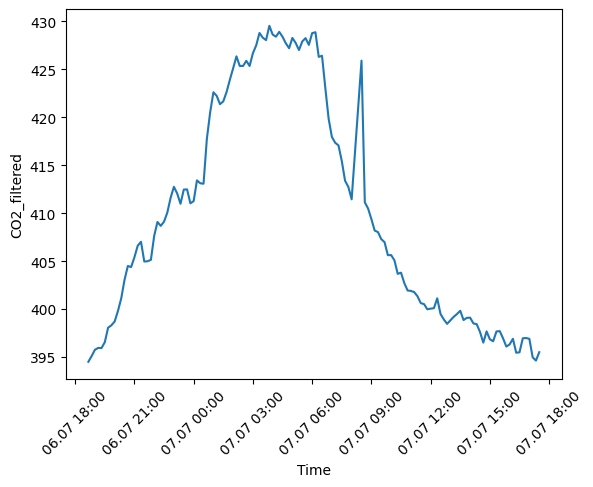

In [90]:
# Plot CO2_Filtered

df_f = df.filter(pl.col("variant") == "measurement") 
df_f = df_f.sort("date").filter(pl.col("CO2_filtered") > 0)
df_f = df_f.groupby_dynamic("date",every='10m').agg(pl.all().exclude('date').mean())

sns.lineplot(data=df_f,
        x='date',
        y='CO2_filtered')


# set axes labels
plt.xlabel('Time')
plt.ylabel('CO2_filtered')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))

# show the plot
plt.show()

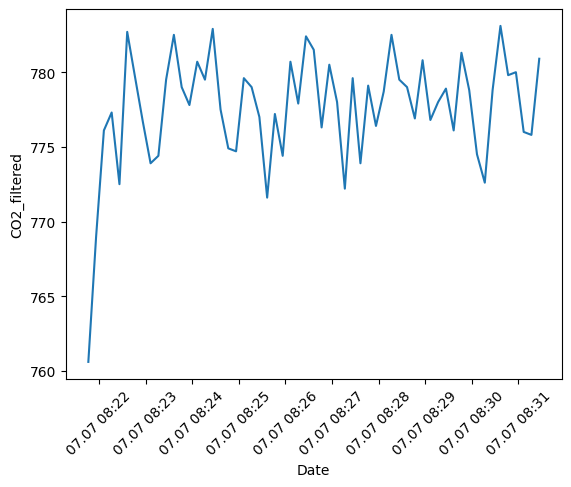

In [91]:
# Plot 800ppm Calibration Bottle 

df_f = df.filter(pl.col("variant") == "calibration") 
df_f = df_f.sort("date").filter(pl.col("CO2_filtered") > 750)
#df_f = df_f.groupby_dynamic("date",every='1h').agg(pl.all().exclude('date').mean())

sns.lineplot(data=df_f,
        x='date',
        y='CO2_filtered')


# set axes labels
plt.xlabel('Date')
plt.ylabel('CO2_filtered')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))

# show the plot
plt.show()

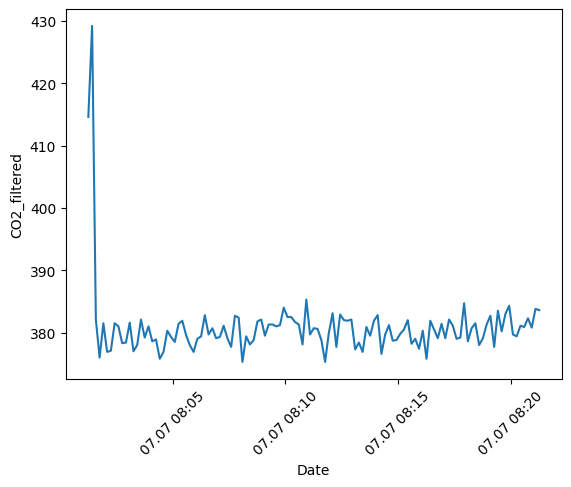

In [92]:
# Plot 400ppm Calibration Bottle 
df_f = df.filter(pl.col("variant") == "calibration") 
df_f = df_f.sort("date").filter(pl.col("CO2_filtered") < 450)
#df_f = df_f.groupby_dynamic("date",every='1h').agg(pl.all().exclude('date').mean())

sns.lineplot(data=df_f,
        x='date',
        y='CO2_filtered')


# set axes labels
plt.xlabel('Date')
plt.ylabel('CO2_filtered')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))

# show the plot
plt.show()

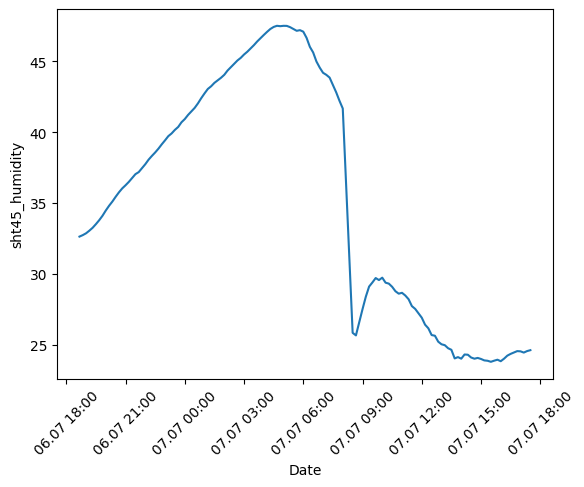

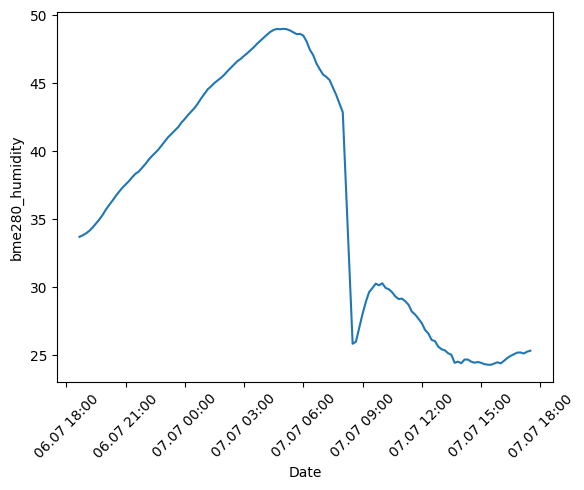

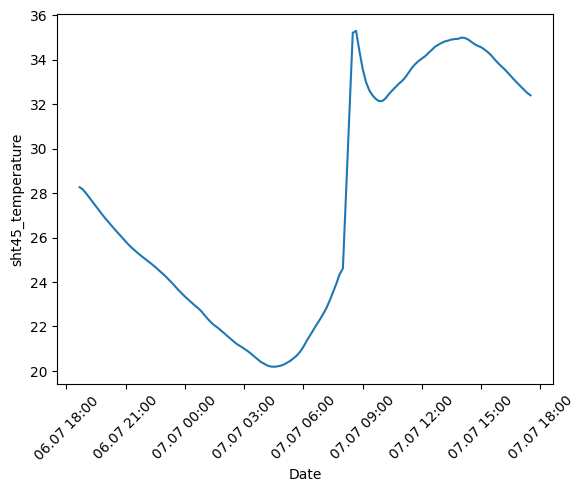

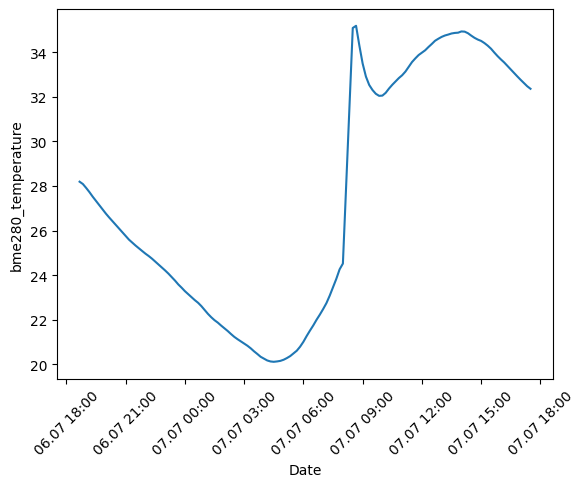

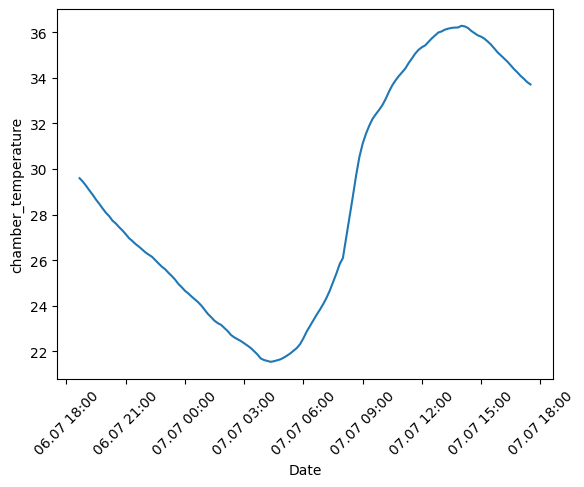

In [93]:
# Plot auxilliary data
plot_sensor_measurement(df, "sht45_humidity")
plot_sensor_measurement(df, "bme280_humidity")
plot_sensor_measurement(df, "sht45_temperature")
plot_sensor_measurement(df, "bme280_temperature")
plot_sensor_measurement(df, "chamber_temperature")


In [94]:
df_w = df_wind
df_w = df_w.with_columns(pl.col("direction_avg").apply(find_closest_cardinal_direction, return_dtype=float).alias("cardinal_direction"))
df_w = df_w.with_columns(pl.col("speed_avg").apply(lambda t: math.ceil(t * 2) / 2, return_dtype=float).alias("strength"))
df_w = df_w.groupby(["cardinal_direction", "strength"]).count().sort("strength")
df_w.head()

cardinal_direction,strength,count
f64,f64,u32
180.0,0.5,3
67.5,0.5,2
202.5,0.5,4
225.0,0.5,1
337.5,0.5,1


In [95]:
fig = px.bar_polar(df_w, r="count", theta="cardinal_direction",
                   color="strength", template="plotly_dark",
                   color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.show()